# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

## Custom

In [6]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates
import src.data.frequencies

import src.models.complete
import src.models.individual
import src.models.unpooled
import src.models.partial
import src.models.vi
import src.models.va
import src.models.rva
import src.models.mrva

import src.models.inference
import src.models.mapping


<br>

## Settings



Aesthetics

In [7]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [8]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [9]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

Seed

In [10]:
RANDOM_SEED = 8924

<br>

## Logging

In [11]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [12]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')

<br>

Extra features

In [13]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


# of instances: (919, 29)
2022-12-10 23:16:35.562


# of unique codes: (919,)
2022-12-10 23:16:35.564



<br>

Frequencies

In [14]:
frequencies = src.data.frequencies.Frequencies().county(data=excerpt)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-10 23:16:35.580



<br>
<br>

# Exploratory Graphs

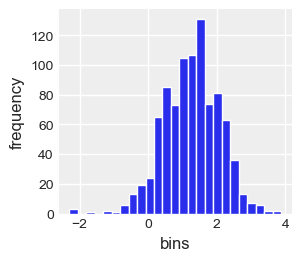

In [15]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [16]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords.keys())


dict_keys(['Level', 'County', 'ArgCholeskyDeviations', 'ArgCholeskyCorrelations'])
2022-12-10 23:16:36.550



<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [17]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-12-10 23:16:38.005


y
2022-12-10 23:16:38.028



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

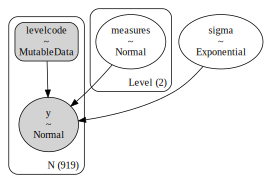

In [18]:
name = 'complete.gv'
dag.exc(model=complete, size='3.7,4.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [19]:
complete_ = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:16:39.260

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:16:39.262

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:16:42.669

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-10 23:16:42.671



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
2022-12-10 23:17:14.517

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-10 23:17:20.504

Sampling: [y]

Sampling: [y]
2022-12-10 23:17:20.670



In [20]:
complete_ = src.models.mapping.Mapping(inferences=complete_, coords=coords).exc()

In [21]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [22]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


    measures  level      type
0   2.052947      0  Basement
1  -9.913842      0  Basement
2   0.317323      0  Basement
3 -27.597240      0  Basement
4   0.027352      0  Basement
2022-12-10 23:17:21.726



<br>

The graph

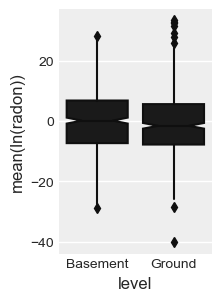

In [23]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [24]:
complete_.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 -0.2166 2.122 1.115 ... 15.11 14.36 14.58
Attributes:
    created_at:                 2022-12-10T23:17:20.623023
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [25]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.807375      1  Ground
1996  0.804608      1  Ground
1997  0.766568      1  Ground
1998  0.782418      1  Ground
1999  0.792767      1  Ground
2022-12-10 23:17:22.137



<br>

The distributions

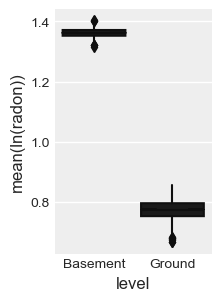

In [26]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [27]:
az.summary(complete_)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
measures[Basement]  1.362  0.029   1.309    1.417      0.000    0.000   
measures[Ground]    0.775  0.064   0.652    0.894      0.001    0.001   
sigma               0.791  0.019   0.754    0.825      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
measures[Basement]    5971.0    3341.0    1.0  
measures[Ground]      5560.0    3027.0    1.0  
sigma                 6233.0    3188.0    1.0

<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

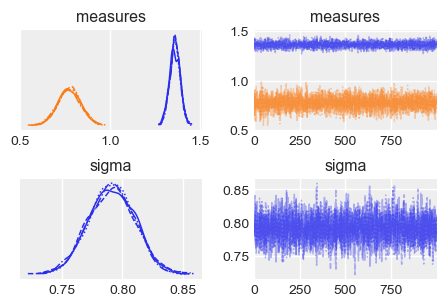

In [28]:
with complete:
    az.plot_trace(data=complete_, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000137ED730>,
      dtype=object)

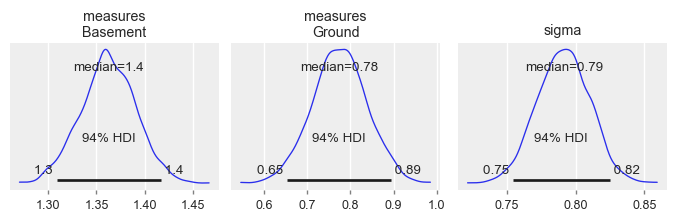

In [29]:
pm.plot_posterior(data=complete_, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [30]:
averages_features = complete_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.362 0.775
    sigma      float64 0.791

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [31]:
hdi_features = az.hdi(complete_)
hdi_features

<xarray.Dataset>
Dimensions:    (Level: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    measures   (Level, hdi) float64 1.309 1.417 0.6521 0.8938
    sigma      (hdi) float64 0.754 0.8248

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

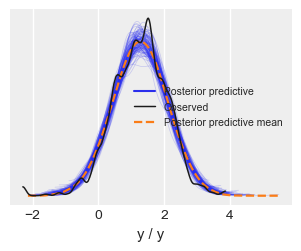

In [32]:
az.plot_ppc(data=complete_, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [33]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    complete_.posterior_predictive.y.groupby(complete_.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.12508137,  2.85145607],
       [-0.72160194,  2.2635155 ]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

<br>

**High Density Intervals, Averages**

Options:

* `sns.scatterplot(y=complete_.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

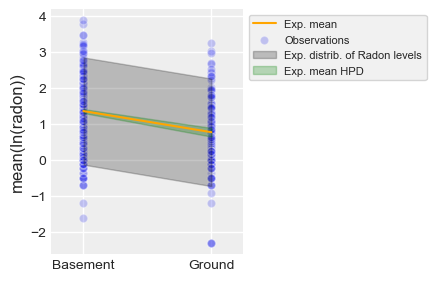

In [34]:
ax = sketch.figure(width=4.25, height=2.7)

complete_.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(complete_.posterior['LevelCode'].values)
ax.set_xticklabels(complete_.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>
<br>

**Clean-up**

In [35]:
del hdi_features, averages_features, hdi_predictive

<br>

### Inference Data

In [36]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Individual

### Model

In [37]:
individual = src.models.individual.Individual(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 23:17:30.853



<br>

An <span style='color: #808080'>illustration</span> of the model

* Similarly: `pm.model_to_graphviz(individual)`

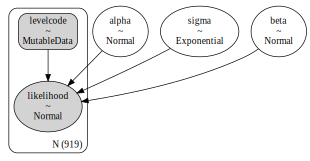

In [38]:
name = 'individual.gv'
dag.exc(model=individual, size='4.3,4.0', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [39]:
individual_ = src.models.inference.Inference(model=individual).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:17:32.366

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:17:32.367

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:17:36.192

NUTS: [alpha, beta, sigma]

NUTS: [alpha, beta, sigma]
2022-12-10 23:17:36.194



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
2022-12-10 23:18:10.124

Sampling: [alpha, beta, likelihood, sigma]

Sampling: [alpha, beta, likelihood, sigma]
2022-12-10 23:18:18.223

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 23:18:18.456



In [40]:
individual_.posterior = individual_.posterior.assign_coords(Level=list(coords['Level'].keys()))
individual_ = src.models.mapping.Mapping(inferences=individual_, coords=coords).exc()

<br>
<br>

### Posterior Measures

<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

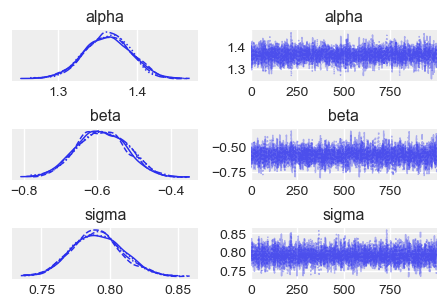

In [41]:
with individual:
    az.plot_trace(data=individual_, figsize=(4.35, 2.95)) 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000139CCCD0>,
      dtype=object)

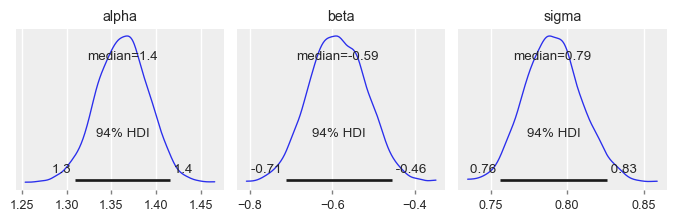

In [42]:
pm.plot_posterior(data=individual_, var_names=['alpha', 'beta', 'sigma'], 
                  figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)   

<br>

**Posterior Measures Mean**

In [43]:
individual_.posterior.mean(dim=('chain', 'draw'))

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    alpha      float64 1.362
    beta       float64 -0.5871
    sigma      float64 0.7909

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [44]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-12-10 23:18:25.626


y
2022-12-10 23:18:25.650



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

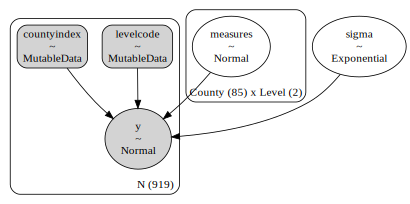

In [45]:
name = 'unpooled.gv'
dag.exc(model=unpooled, size='5.7,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [46]:
unpooled_ = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:18:27.059

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:18:27.061

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:18:30.682

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-10 23:18:30.684



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
2022-12-10 23:19:26.853

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-10 23:19:33.861

Sampling: [y]

Sampling: [y]
2022-12-10 23:19:34.041



In [47]:
unpooled_ = src.models.mapping.Mapping(inferences=unpooled_, coords=coords).exc()

In [48]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [49]:
az.summary(unpooled_)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
measures[AITKIN, Basement]           0.676  0.416  -0.042    1.490      0.007   
measures[AITKIN, Ground]             0.824  0.724  -0.459    2.219      0.011   
measures[ANOKA, Basement]            0.954  0.106   0.751    1.151      0.002   
measures[ANOKA, Ground]             -0.133  0.410  -0.921    0.609      0.006   
measures[BECKER, Basement]           1.473  0.721   0.112    2.833      0.011   
...                                    ...    ...     ...      ...        ...   
measures[WRIGHT, Basement]           1.671  0.201   1.281    2.046      0.003   
measures[WRIGHT, Ground]             0.862  0.730  -0.439    2.276      0.011   
measures[YELLOW MEDICINE, Basement]  1.202  0.499   0.232    2.105      0.008   
measures[YELLOW MEDICINE, Ground]    0.018  9.771 -18.517   17.871      0.141   
sigma                                0.719  0.019   0.685    0.755      0.000   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
measures[AITKIN, Basement]             0.005    3716.0    2735.0   1.00  
measures[AITKIN, Ground]               0.009    4244.0    2831.0   1.00  
measures[ANOKA, Basement]              0.001    4703.0    2896.0   1.00  
measures[ANOKA, Ground]                0.007    5334.0    2919.0   1.00  
measures[BECKER, Basement]             0.008    4133.0    2648.0   1.00  
...                                      ...       ...       ...    ...  
measures[WRIGHT, Basement]             0.002    4083.0    2876.0   1.00  
measures[WRIGHT, Ground]               0.009    4523.0    2567.0   1.00  
measures[YELLOW MEDICINE, Basement]    0.006    4078.0    2607.0   1.00  
measures[YELLOW MEDICINE, Ground]      0.181    4825.0    2081.0   1.01  
sigma                                  0.000    3364.0    2950.0   1.00  

[171 rows x 9 columns]

<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

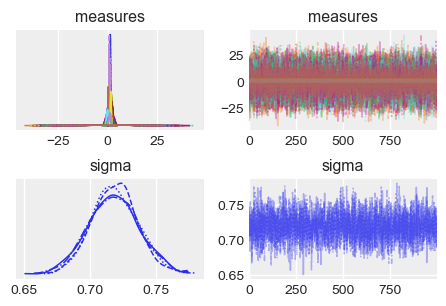

In [50]:
with unpooled:
    az.plot_trace(data=unpooled_, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

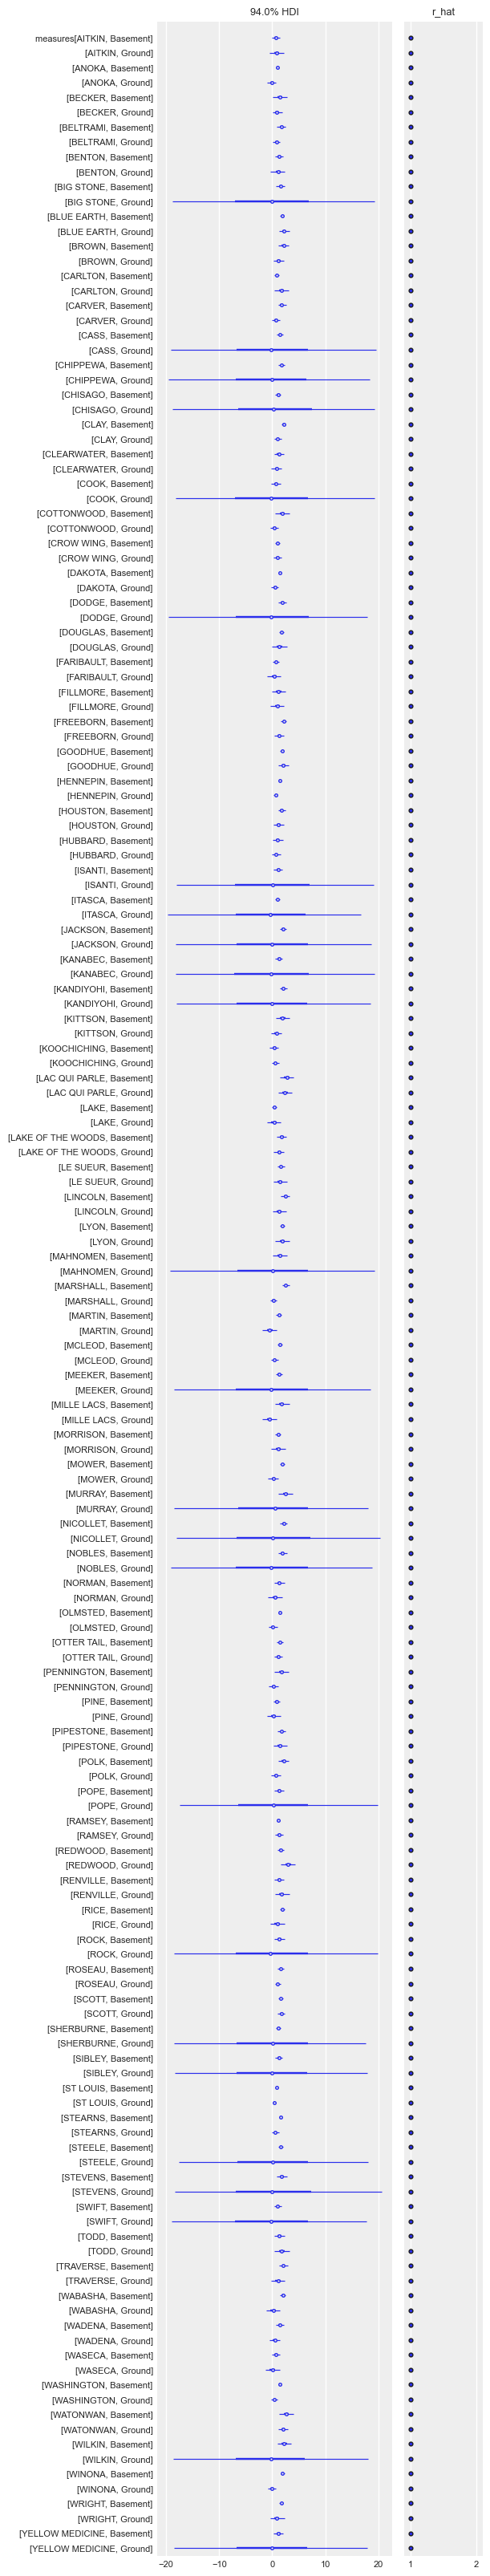

In [51]:
az.plot_forest(
    unpooled_, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [52]:
averages_features = unpooled_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (County, Level) float64 0.6759 0.8242 0.9535 ... 1.202 0.01759
    sigma        float64 0.7188

<br>

**Posterior Check**

In [53]:
hdi_features = az.hdi(unpooled_)
hdi_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (County, Level, hdi) float64 -0.04219 1.49 ... -18.52 17.87
    sigma        (hdi) float64 0.6848 0.7551

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


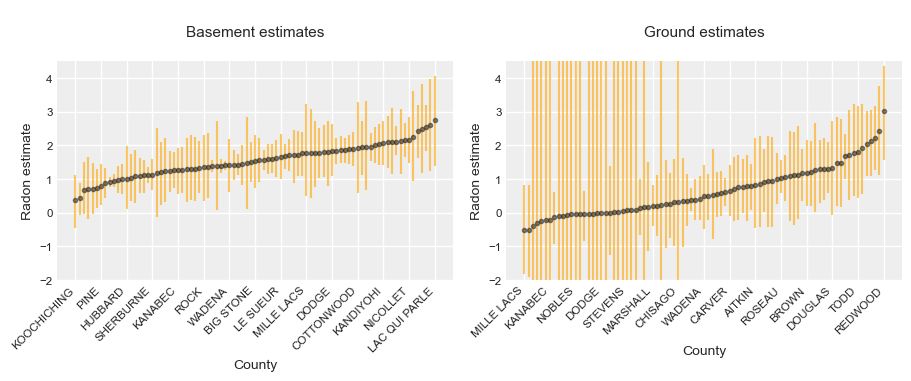

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)
    

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [55]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [56]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [57]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.927879         WATONWAN         80.0    1.0  2.0
81   36.628600           WILKIN          NaN    NaN  NaN
82    1.495302           WINONA         82.0    1.0  3.0
83    2.715055           WRIGHT         83.0    1.0  1.0
84   36.388823  YELLOW MEDICINE          NaN    NaN  NaN
2022-12-10 23:20:11.816



<br>

Some counties do not have any ground level data points

In [58]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.927879         WATONWAN         80.0    1.0  2.0
81   36.628600           WILKIN          NaN    NaN  0.0
82    1.495302           WINONA         82.0    1.0  3.0
83    2.715055           WRIGHT         83.0    1.0  1.0
84   36.388823  YELLOW MEDICINE          NaN    NaN  0.0
2022-12-10 23:20:11.832



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

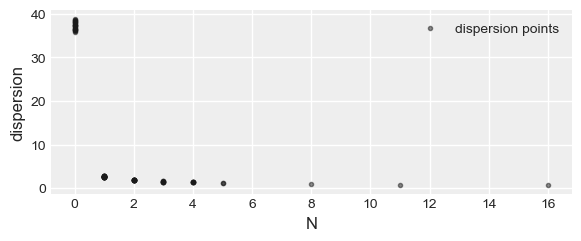

In [59]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

Upcoming

<br>
<br>

**Estimates**

Upcoming

In [60]:
averages_features['measures'].sel(County='AITKIN')

<xarray.DataArray 'measures' (Level: 2)>
array([0.67587598, 0.82419343])
Coordinates:
    County   <U17 'AITKIN'
  * Level    (Level) <U8 'Basement' 'Ground'

In [61]:
unpooled_.observed_data['y'][unpooled_.observed_data.coords['County'] == 'AITKIN']

<xarray.DataArray 'y' (N: 4)>
array([0.83290912, 1.09861229, 0.09531018, 0.83290912])
Coordinates:
  * N            (N) int32 1 2 3 0
    Level        (N) <U8 'Basement' 'Basement' 'Basement' 'Ground'
    LevelCode    (N) int32 0 0 0 1
    County       (N) <U17 'AITKIN' 'AITKIN' 'AITKIN' 'AITKIN'
    CountyIndex  (N) int32 0 0 0 0

<br>
<br>

**Clean-up**

In [62]:
del hdi_features, hdi_, averages_features, averages_

<br>
<br>

### Inference Data

In [63]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Partial

### Model

In [64]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex]: (919,)
2022-12-10 23:20:13.208


likelihood
2022-12-10 23:20:13.231



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

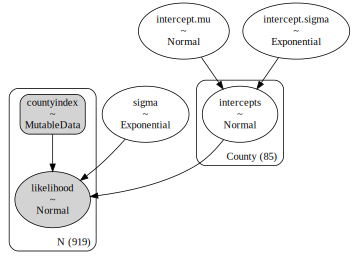

In [65]:
name = 'partial.gv'
dag.exc(model=partial, size='4.9,4.1', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [66]:
partial_ = src.models.inference.Inference(model=partial).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:20:14.971

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:20:14.972

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:20:19.768

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]
2022-12-10 23:20:19.771



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
2022-12-10 23:21:06.507

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 23:21:13.241

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 23:21:13.439



In [67]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

Enrich

In [68]:
partial_ = src.models.mapping.Mapping(inferences=partial_, coords=coords).exc()

In [69]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Preliminaries**

The frequencies

In [70]:
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-10 23:21:14.656



<br>

Tallies by county only.

In [71]:
T = frequencies.groupby(by=['county', 'countyindex']).agg(N=('N', sum))
T.reset_index(drop=False, inplace=True)
K = T.copy().set_index(keys='countyindex')

logger.info(T.tail())
logger.info(K.tail())


             county  countyindex   N
80         WATONWAN           80   3
81           WILKIN           81   1
82           WINONA           82  13
83           WRIGHT           83  13
84  YELLOW MEDICINE           84   2
2022-12-10 23:21:14.681


                      county   N
countyindex                     
80                  WATONWAN   3
81                    WILKIN   1
82                    WINONA  13
83                    WRIGHT  13
84           YELLOW MEDICINE   2
2022-12-10 23:21:14.686



<br>

Extra co${\ddot{o}}$rdinates



> ```python 
indices[-5:]


In [72]:
indices = partial_.posterior.coords['CountyIndex'].values

In [73]:
partial_.posterior = partial_.posterior.assign_coords({'Tally': ('County', K.iloc[indices, :]['N'].array)})

In [74]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

**Posterior Mean**

In [75]:
averages_features = partial_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:          (County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
Data variables:
    intercept.mu     float64 1.35
    intercepts       (County) float64 1.099 0.9419 1.265 ... 1.446 1.524 1.316
    intercept.sigma  float64 0.3052
    sigma            float64 0.7665

<br>

**Posterior Check**

In [76]:
hdi_features = az.hdi(partial_)
hdi_features

<xarray.Dataset>
Dimensions:          (hdi: 2, County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    intercept.mu     (hdi) float64 1.262 1.437
    intercepts       (County, hdi) float64 0.6235 1.528 0.7644 ... 0.7977 1.808
    intercept.sigma  (hdi) float64 0.2171 0.3946
    sigma            (hdi) float64 0.7318 0.8008

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages,Tallies**

County tally, posterior mean, and high density interval.  `Either`

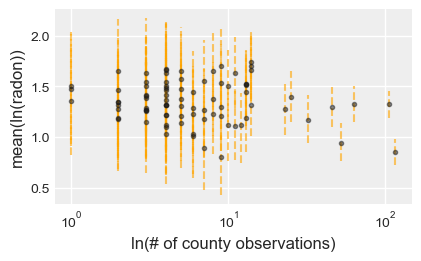

In [77]:
ax = sketch.figure(width=4.1, height=2.5)

# scatter plot
ax.plot(averages_features.coords['Tally'].values, averages_features['intercepts'].values, 'ok', markersize=3, alpha=0.5);

# high density interval lines
ax.vlines(
    hdi_features.coords['Tally'].values,
    hdi_features['intercepts'].sel(hdi='lower').values,
    hdi_features['intercepts'].sel(hdi='higher').values,
    color='orange',
    linestyles='dashed',
    alpha=0.6,
)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>

`Or`

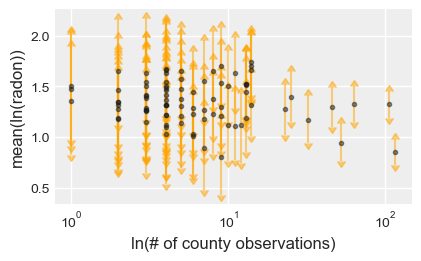

In [78]:
ax = sketch.figure(width=4.1, height=2.5)

# limits
X = np.concatenate((np.expand_dims(hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values, axis=0)))

points = averages_features['intercepts'].values
Y = np.concatenate((np.expand_dims(points - hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values - points, axis=0)))

# graph
ax.errorbar(averages_features.coords['Tally'].values, 
            averages_features['intercepts'].values, 
            Y, 
            uplims=True, lolims=True,
            ecolor='orange', 
            marker='o', markersize=3, markerfacecolor='k', markeredgecolor='k', 
            linestyle='',
            alpha=0.5)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>
<br>

**Clean-up**

In [79]:
del X, Y, hdi_features, averages_features

<br>
<br>

### Inference Data

In [80]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Varying Intercept

### Model

In [81]:
vi = src.models.vi.VI(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex] + (beta * levelcode): (919,)
2022-12-10 23:21:21.448


likelihood
2022-12-10 23:21:21.468



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(vi)`

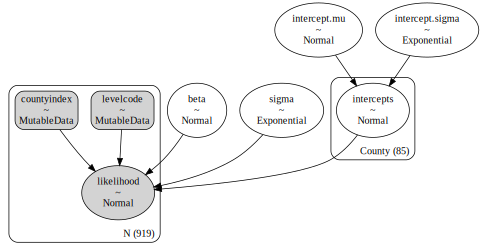

In [82]:
name = 'vi.gv'
dag.exc(model=vi, size='6.7,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [83]:
vi_ = src.models.inference.Inference(model=vi).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:21:23.387

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:21:23.389

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:21:28.571

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]
2022-12-10 23:21:28.573



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
2022-12-10 23:22:18.438

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 23:22:27.988

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 23:22:28.275



In [84]:
vi_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Summary**: The mean & deviation of the random intercepts, the common gradient $\beta$, the deviation $\sigma$ of the model's error

In [85]:
az.summary(vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept.mu     1.492  0.052   1.396    1.589      0.001    0.001    1616.0   
intercept.sigma  0.319  0.046   0.238    0.406      0.001    0.001    1232.0   
beta            -0.662  0.067  -0.782   -0.531      0.001    0.001    2414.0   
sigma            0.727  0.018   0.694    0.760      0.000    0.000    3491.0   

                 ess_tail  r_hat  
intercept.mu       2257.0    1.0  
intercept.sigma    2005.0    1.0  
beta               2546.0    1.0  
sigma              3087.0    1.0

<br>
<br>

**Graphs**: The mean & deviation of the random intercepts, the common gradient $\beta$, the deviation $\sigma$ of the model's error

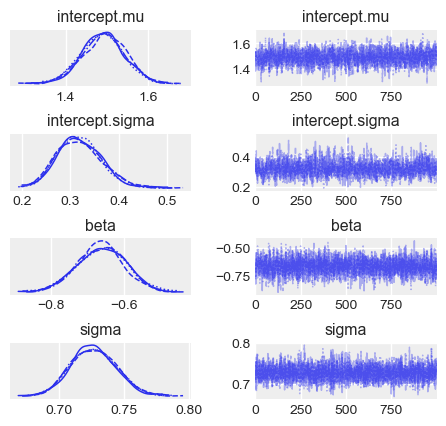

In [86]:
with vi:
    az.plot_trace(data=vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'], 
                 figsize=(4.35, 4.15))

<br>

Cf.

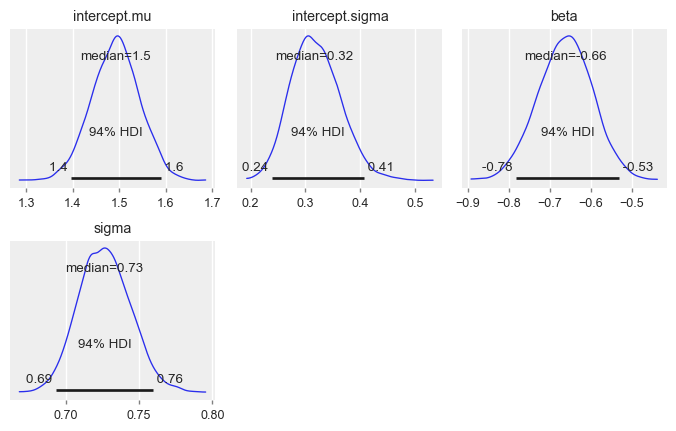

In [87]:
pm.plot_posterior(data=vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'], 
                 figsize=(6.65, 4.2), grid=(2, 3), point_estimate='median', textsize=9);

<br>
<br>

## Varying Intercept, Varying Gradient


$y_{_{i}} = \alpha_{_{i, j}} + \beta_{_{i, j}}x_{_{i}} + \epsilon_{_{i}}$

where 

> $i = 1, \ldots, N$
>
> $j = 1, \ldots, J$

and

> $\mathbf{\epsilon} \sim \mathcal{N}(0, \sigma^{\tiny{2}}_{_{y}}\mathbf{I})$

$i$ denotes the observation unit, there are $N$ observations. $\alpha_{_{i,j}}$ is the varying intercept term, and $\beta_{_{i,j}}$ is the varying gradient term, such that unit $i$ is a member of group $j$; there are $J$ groups.

In [88]:
va = src.models.va.VA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 23:22:37.462



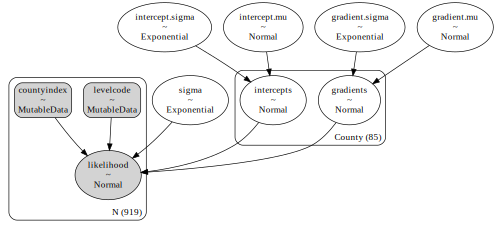

In [89]:
name = 'va.gv'
dag.exc(model=va, size='6.9,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

In [90]:
va_ = src.models.inference.Inference(model=va).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:22:40.855

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:22:40.856

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:22:47.898

NUTS: [intercept.mu, intercept.sigma, intercepts, gradient.mu, gradient.sigma, gradients, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, gradient.mu, gradient.sigma, gradients, sigma]
2022-12-10 23:22:47.899



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 159 seconds.
2022-12-10 23:25:26.945

Sampling: [gradient.mu, gradient.sigma, gradients, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [gradient.mu, gradient.sigma, gradients, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 23:25:35.856

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 23:25:36.141



In [91]:
va_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

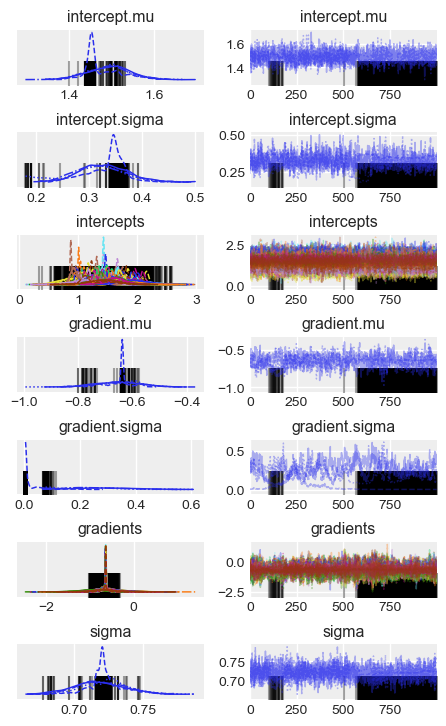

In [92]:
with va:
    az.plot_trace(data=va_, var_names=['intercept.mu', 'intercept.sigma', 'intercepts', 
                                       'gradient.mu', 'gradient.sigma', 'gradients', 'sigma'], 
                 figsize=(4.35, 7.15))

<br>
<br>

## Varying Intercept, Varying Gradient, Non-centred Parameterisation

In [93]:
rva = src.models.rva.RVA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 23:26:10.165



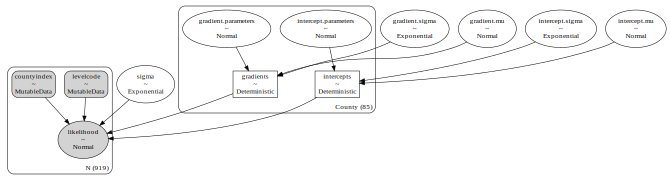

In [94]:
name = 'rva.gv'
dag.exc(model=rva, size='9.3,8.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

In [95]:
rva_ = src.models.inference.Inference(model=rva).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:26:12.916

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:26:12.918

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:26:19.830

NUTS: [intercept.mu, intercept.sigma, intercept.parameters, gradient.mu, gradient.sigma, gradient.parameters, sigma]

NUTS: [intercept.mu, intercept.sigma, intercept.parameters, gradient.mu, gradient.sigma, gradient.parameters, sigma]
2022-12-10 23:26:19.832



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.
2022-12-10 23:27:31.165

Sampling: [gradient.mu, gradient.parameters, gradient.sigma, intercept.mu, intercept.parameters, intercept.sigma, likelihood, sigma]

Sampling: [gradient.mu, gradient.parameters, gradient.sigma, intercept.mu, intercept.parameters, intercept.sigma, likelihood, sigma]
2022-12-10 23:27:38.905

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 23:27:39.212



In [96]:
rva_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

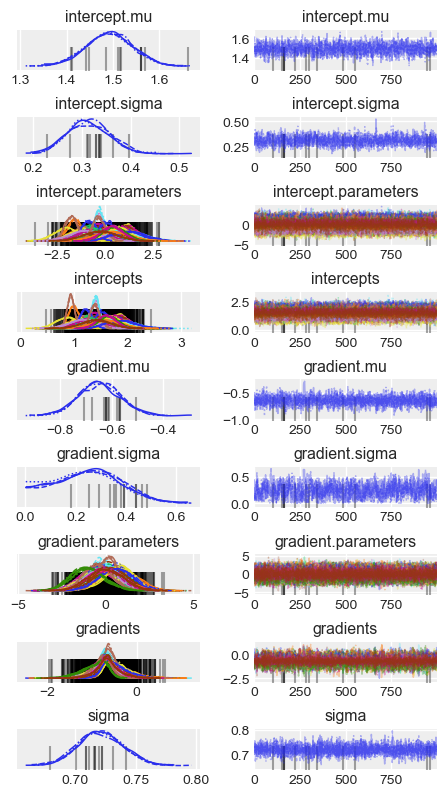

In [97]:
with rva:
    az.plot_trace(data=rva_, var_names=['intercept.mu', 'intercept.sigma', 'intercept.parameters', 'intercepts', 
                                       'gradient.mu', 'gradient.sigma', 'gradient.parameters', 'gradients', 
                                       'sigma'], 
                 figsize=(4.35, 7.85))

<br>
<br>

## Varying Intercept, Varying Gradient, Non-centred Parameterisation, MVN

In [98]:
mrva = src.models.mrva.MRVA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 23:28:35.616



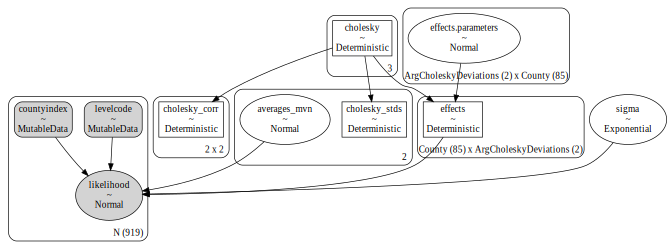

In [99]:
name = 'mrva.gv'
dag.exc(model=mrva, size='9.3,8.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

In [100]:
with mrva:
    mrva_ = pm.sample(draws=1000, cores=None, tune=3000, target_accept=0.95, 
                      idata_kwargs={'dims': {'CholeskyDeviations': ['ArgCholeskyDeviations'], 
                                             'CholeskyCorrelations': ['ArgCholeskyDeviations', 'ArgCholeskyCorrelations']}})

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 23:28:40.884

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 23:28:40.886

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 23:28:52.470

NUTS: [cholesky, averages_mvn, effects.parameters, sigma]

NUTS: [cholesky, averages_mvn, effects.parameters, sigma]
2022-12-10 23:28:52.471



Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 260 seconds.

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 260 seconds.
2022-12-10 23:33:14.165



In [101]:
mrva_

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

<br>
<br>
<br>

# Clean-up

In [102]:
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

The cleaning-up scripts, in relation to the current directory.

In [103]:
%%bash

# The list of files in directory notebooks/
ls -l notebooks/

# Deleting the directed acyclic graphs of the models
rm -rf notebooks/*.gv
rm -rf notebooks/*.gv.pdf

# Inspect notebooks
ls -l notebooks/



total 3287
-rw-r--r-- 1 Think 197121       0 Dec  1 12:50 __init__.py
-rw-r--r-- 1 Think 197121     539 Dec 10 23:16 complete.gv
-rw-r--r-- 1 Think 197121   23516 Dec 10 23:16 complete.gv.pdf
-rw-r--r-- 1 Think 197121     548 Dec 10 23:17 individual.gv
-rw-r--r-- 1 Think 197121   23644 Dec 10 23:17 individual.gv.pdf
-rw-r--r-- 1 Think 197121    1627 Dec 10 23:28 mrva.gv
-rw-r--r-- 1 Think 197121   28774 Dec 10 23:28 mrva.gv.pdf
-rw-r--r-- 1 Think 197121   87181 Nov 17 18:56 odds.ipynb
-rw-r--r-- 1 Think 197121     806 Dec 10 23:20 partial.gv
-rw-r--r-- 1 Think 197121   25182 Dec 10 23:20 partial.gv.pdf
-rw-r--r-- 1 Think 197121 4893159 Dec 10 23:32 radon.ipynb
-rw-r--r-- 1 Think 197121    1441 Dec 10 23:26 rva.gv
-rw-r--r-- 1 Think 197121   26839 Dec 10 23:26 rva.gv.pdf
-rw-r--r-- 1 Think 197121     673 Dec 10 23:18 unpooled.gv
-rw-r--r-- 1 Think 197121   24867 Dec 10 23:18 unpooled.gv.pdf
-rw-r--r-- 1 Think 197121    1197 Dec 10 23:22 va.gv
-rw-r--r-- 1 Think 197121   26475 Dec 10 23: